<div align="right" style="text-align: right"><i>Peter Norvig<br>2012, 2020, 2021</i></div>

# The Unfinished Game ... of Risk

[Keith Devlin](https://web.stanford.edu/~kdevlin/)'s [book](https://www.amazon.com/Unfinished-Game-Pascal-Fermat-Seventeenth-Century/dp/0465018963) [*The Unfinished Game*](https://wordplay.blogs.nytimes.com/2015/12/14/devlin-unfinished-game/) describes how Fermat and Pascal discovered the rules of probability that guide gambling in games. The question they confronted was: what if a gambling game is interrupted, but one player is in the lead by a certain score. How much of the pot should the leader get?

My friends and I faced a similar question when a game of [*Risk*](https://www.ultraboardgames.com/risk/game-rules.php) ran on too long (as they often do) and we were unable to finish. Player **A**  was poised to make a sweeping attack on player **D**, whose territories were arranged in such a way that **A** could attack from one territory to the next without ever having to branch off.  We wrote down the number of **A**'s massed armies, **72**, and the number of armies in **D**'s successive territories: **22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1.** What is the probability that **A** can capture all these territories?

![](https://www.ultraboardgames.com/risk/gfx/board.jpg)

______

# Terminology

Let's explain some *Risk* [rules](https://www.ultraboardgames.com/risk/game-rules.php) and terminology:

- A **battle** is when armies from one territory attack an enemy neighboring territory. A roll of dice determines which armies perish:
  - The attacker will roll 3 dice if possible (but no more than the number of armies in the attacking territory minus one).
  - The defender will roll 2 dice if possible (or only one die if they have only one army defending). 
  - The **outcome** of the battle is determined by comparing the highest die from each of the two players, with the defender losing an army if the attacker's die is higher, and the attacker losing an army if tied or lower. Then if both sides rolled at least two dice, we do the same comparison with the second highest die on each side. 
  - When a battle kills off the last defender in a territory, the attackers **occupy** the territory. They must leave behind one army, but can move the rest in.  

- A **campaign** consists of a sequence of battles and occupations. In this notebook we will consider only a **chain campaign**, in which attackers invade successive enemy territories in order, always moving all their remaining armies into each captured territory, never branching, and never changing strategy based on the outcome of a battle. The attackers **win** the campaign if they occupy all the territories. The attackers **lose** if there are any remaining defenders and only one remaining attacker, who by rule cannot attack. 



With that out of the way, we're ready for some Python implementation.

In [1]:
from typing      import List, Iterable
from collections import Counter
from functools   import lru_cache
import random
import itertools
import matplotlib.pyplot as plt

# Representing the State of a Campaign

I will represent the **state of a campaign** as a tuple where the first element is the number of attacking armies, and subsequent elements are the number of defenders in each successive territory. Thus we can represent the start state of our unfinished campaign as follows:

In [2]:
State = tuple

start = State((72, 22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1))

I'll define the following functions on states: 
- `A(state)`: the number of attackers in a state.
- `D(state)`: the number of defenders in the defender's first territory (or `0` if there are no defenders at all).
- `allD(state)`: the tuple of numbers of defenders in each territory.
- `update(state, dead)`: a new state reflecting the aftermath of a battle that leads to  `dead` armies, where `dead` is a two-element tuple of (attackers-who-died, defenders-who-died). The attackers will occupy the first territory if all the defenders in the first territory died.  Note that `dead` is a slightly different usage of `State`, counting the number of deaths rather than the number of living armies.

In [3]:
def A(state)    -> int:   "Attackers";       return state[0]
def D(state)    -> int:   "First defenders"; return state[1] if allD(state) else 0
def allD(state) -> tuple: "All defenders";   return state[1:]

Deaths = State # A kind of state where (A, D) means that A attackers and D defenders died

def update(state, dead: Deaths) -> State:
    """Update the `state` of a campaign to reflect the`dead` in a battle."""
    a, d, ds = A(state) - A(dead), D(state) - D(dead), allD(state)[1:]
    if d: # Can't occupy first territory if there are defenders there 
        return State((a, d, *ds))
    else: # Occupy territory, leaving 1 behind
        return State((a - 1, *ds))

In [4]:
A(start)

72

In [5]:
D(start)

22

In [6]:
allD(start)

(22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1)

# Rolling the Dice and the Outcome of a Single Battle

We'll represent a roll of the dice with a list of integers; for example the attacker might roll `[2, 6, 1]` with three dice. The function `random_roll(n)` gives a random outcome for rolling `n` dice. The function `battle_deaths`, when given the specific sets of dice rolled by attacker and defender in a battle, returns a two-element `State` tuple that gives the number of attackers and defenders who perish in the battle.

In [7]:
die  = (1, 2, 3, 4, 5, 6)
Dice = List[int] # a list of die rolls, like [2, 6, 1]

def random_roll(n) -> Dice:
    """Roll n dice randomly."""
    return [random.choice(die) for _ in range(n)]

def battle_deaths(A_dice: Dice, D_dice: Dice) -> Deaths:
    """How many (attacker, defender) armies perish as the result of these dice?"""
    dead = Counter('D' if a > d else 'A'
                   for a, d in zip(sorted(A_dice, reverse=True), 
                                   sorted(D_dice, reverse=True)))
    return Deaths((dead['A'], dead['D']))

In [8]:
random_roll(3) # Example roll

[3, 3, 6]

# Monte Carlo Simulation of a Campaign

A [**Monte Carlo simulation**](https://en.wikipedia.org/wiki/Monte_Carlo_method) makes random choices at every choice point (here, every dice roll), and reports on the outcome. 

The function `simulate_campaign` rolls random dice for a battle until we've reached a terminal state where there can be no more battles (either because the defenders have all been defeated, or because the attackers do not have the two armies necessary to launch an attack).

In [9]:
def simulate_campaign(state) -> State:
    """Simulate a campaign with random rolls, returning the final state."""
    while not terminal(state):
        dead  = battle_deaths(random_roll(min(3, A(state))), 
                              random_roll(min(2, D(state))))
        state = update(state, dead)
    return state

def terminal(state) -> bool: 
    """Is the game over?"""
    return A(state) < 2 or not D(state)

# Finishing the Unfinished Game (Randomly)

**Let's see who wins!**

In [10]:
simulate_campaign(start)

(9,)

That final state says that the attackers won—there are 9 attackers and no defenders left. 

# Predicting the Unfinished Game: Estimating Probabilities

But what if we want to know not just who won that one game, but what is the **probability** that the attackers win? Monte Carlo simulation answers that question by repeating a simulation many times and **summarizing** all the final outcomes. The summary is in the form of a **probability distribution**, a mapping of `{outcome_state: probability}` pairs, which I have implemented as `ProbDist`. I implemented `ProbDist` as a subclass of `Counter`, with the restriction that the values are normalized to sum to 1. (I realize that the name  `Counter` suggests integer counts, but that's not a requirement, and `Counter` has a nicer API than `dict`, including  a default value of 0  and the `most_common` method.)

In [11]:
class ProbDist(Counter): 
    "A Probability Distribution."
    def __init__(self, *args):
        Counter.__init__(self, *args)
        total = sum(self.values())
        for x in self:
            self[x] /= total 

In [12]:
ProbDist('HELLOWORLD') # example probability distribution over 10 letters

ProbDist({'H': 0.1,
          'E': 0.1,
          'L': 0.3,
          'O': 0.2,
          'W': 0.1,
          'R': 0.1,
          'D': 0.1})

The higher-order function `monte_carlo` works with any random simulation function, calling it `k` times, each time passing in a `start` state, and collecting the `k` outcome states in a `ProbDist`:

In [13]:
def monte_carlo(simulation, start, k=1000) -> ProbDist:
    "Call simulation(start) repeatedly (k times) and return a ProbDist of outcomes."
    return ProbDist(simulation(start) for _ in range(k))

Here we run the campaign 
simulation 10 times and see the summary of outcomes:

In [14]:
monte_carlo(simulate_campaign, start, 10)

ProbDist({(4,): 0.1,
          (15,): 0.1,
          (20,): 0.1,
          (1, 1, 5, 1): 0.1,
          (16,): 0.2,
          (11,): 0.1,
          (6,): 0.1,
          (12,): 0.1,
          (8,): 0.1})

And here we run it 1,000 times and report the probability that the attackers win:

In [15]:
def attacker_win_probability(dist: ProbDist) -> float: 
    """The probability that the attackers win the campaign."""
    return sum(dist[s] for s in dist if not allD(s))

In [16]:
attacker_win_probability(monte_carlo(simulate_campaign, start, 1000))

0.7960000000000003

How accurate is that result? We can run it again and compare:

In [17]:
attacker_win_probability(monte_carlo(simulate_campaign, start))

0.8300000000000003

Alernatively, we could  do some math: the standard deviation of the expected value of a [binomial variable](https://www.mathsisfun.com/data/binomial-distribution.html) is $\sqrt{p(1-p)/n}$, where $p$ is the true probability of one of the two outcomes and $n$ is the number of samples. In our case $\sqrt{0.8(1-0.8)/1000}$ gives a standard deviation of about 1%. So we can be pretty confident (but not certain) 
that the true percentage is somewhere between 77% and 86%.

We could get better accuracy at the cost of increased computing time.  It took about half a second to do 1,000 simulations; to get the standard deviation down by a factor of 10 to 0.1% would require 100 times more computing time (because of the square root in the formula), about a minute. To get to 0.01% would require 100 minutes.  

# Monte Carlo Simulation versus Exact Probability Calculation

An alternative to the Monte Carlo approach is an approach that explicitly calculates the exact probability distribution of the final state of ther campaign. The differences between the two approaches are:

- The **Monte Carlo approach** deals with a **single current state**, using random dice rolls to decide how that state changes. At the end of a simulated campaign we get a single final state, and we repeat the simulation to get an **estimated** probability distribution over final states.

- The **exact probability calculation approach** deals with a **probability distribution over states**, right from the start. At each dice roll, every possible outcome is considered, and the probability distribution is updated to reflect all the outcomes and their probabilities. At the end of the campaign we have an **exact** probability distribution over all possible final states (well, exact at least to the limits of floating point precision; if you need even more precision, use `fractions.Fraction`).

In deciding whether to use the exact calculation approach, there are three considerations:

- **Is it worth the effort?** If I only wanted to know whether the attackers chance of winning is more or less than 50%, then the Monte Carlo approach is the simplest way to answer the question. The code will be simple and straightforward. If I need 0.0001% precision on the win probability, then exact calculation is called for.
- **Is it possible?** The exact calculation approach only works for **finite games**. 
- **Is it feasible?** Computation may take too long if there are too many possible states of the game.

**Worth the effort?** In general, the code for an exact calculation is more complex than for a Monte Carlo simulation, and thus it will take more time to write the code, and there will be more opportunity for bugs to sneak in. Monte Carlo code deals with the single current state of the simulation, for example: 

     while not terminal(state):
     
But in the exact calculation we need to consider every possible states (referenced in a loop):

    while any(not terminal(state) for state in probdist):
    
Adding all these loops to the code makes it more complex.

**Possible?** Imagine a *Risk* rule change where if the attackers roll three 6s and the defneders roll two 6s, then both sides *gain* an army. For the Monte Carlo simulation it would be trivial to add a single `if` statement to handle this rule, and the expected run time of the program would hardly change. But with the exact calculation everything has changed, because we now have an  **infinite** game, where there will always be some possible state that has not terminated. (To deal with these we would have to make some compromises, such as stopping the calculation when there are still some nonterminal states, as long as they have very low probability.)

**Feasible?** Imagine that before each battle, every army independently has the option to take one of ten possible actions (e.g. to move to a safe neighboring territory). Then with 100 armies, the very first move has $10^{100}$ outcomes, meaning that the probability distribution requires more states than the number of atoms in the universe. (To deal with this we would either stick with the Monte Carlo simulation, or a varioant of it such as [particle filtering](https://en.wikipedia.org/wiki/Particle_filter) in which we maintain a **sample** of several possible states–more than a single state, but less than the complete state distribution.)

 The *Risk* campaign problem as it stands leads to a very efficient exact probability calculation (possible, feasible, and worth it, IMHO). If there are $n$ total armies to start, then there are fewer than $n^2$ possible states, and the game can last no more than $n$ moves. With $n$ in the range of a few hundred, computation takes less than a second; much faster and more accurate than doing 100,000 simulations.

# Exact Probability Distribution over a Battle

The function `battle_deaths` was defined above to return the specific death counts for a specific dice roll. 

Now we'll define `battle_deaths_probdist` to give a probability distribution over all possible battle outcomes, corresponding to all possible dice rolls. The input to `battle_deaths_probdist` is a state giving the number of attacking and defending armies for just this one battle (not the total number of attacking and defending armies). Thus, the attackers will always be 3, 2, or 1, and the defenders will always be 2 or 1. I define it this way, rather than passing in the full state of the campaign, so that I can **cache** the results and reuse them in subsequent battles, for efficiency.

In [18]:
@lru_cache()
def battle_deaths_probdist(state) -> ProbDist:
    """A probability distribution of deaths in a battle."""
    return ProbDist(battle_deaths(A_dice, D_dice)
                    for A_dice in rolls(A(state))
                    for D_dice in rolls(D(state)))

def rolls(n) -> Iterable[Dice]: 
    """All possible rolls of `n` dice."""
    return itertools.product(die, repeat=n)

In [19]:
battle_deaths_probdist((3, 2)) # Three attacker dice against two defender dice

ProbDist({(2, 0): 0.2925668724279835,
          (1, 1): 0.3357767489711934,
          (0, 2): 0.37165637860082307})

# Exact Probability Distribution over a Campaign

The function `campaign_probdist` mimics `campaign`, except that the former updates a `ProbDist` whereas the later updates a `State`. We start with certainty: there is a 100% chance that we are initially in the `start` state. But the [fog of war](https://en.wikipedia.org/wiki/Fog_of_war) means that uncertainty arises: we don't know how the dice will land, so we don't know the outcome of the very first battle. Subsequent battles add more uncertainty. 

The function `campaign_probdist` calls the function `battle_update_probdist` to update the probability distribution to account for one battle, in all the possible ways it can turn out. The key line in `battle_update_probdist` is

    outcomes[update(state, dead)] += probdist[state] * dead_probdist[dead]
    
which tells us to consider the outcome in which `dead` is the number of attackers and defenders that die in a battle, and to update `state` with those death counts, and increment the probability of that updated outcome by the product of the probability of `state` and the probability of `dead` given `state`.

In [20]:
def campaign_probdist(start: State) -> ProbDist:
    """Probability distribution for all outcomes of a campaign."""
    probdist = ProbDist({start: 1.0})
    while any(not terminal(state) for state in probdist):
        probdist = battle_update_probdist(probdist)
    return probdist

def battle_update_probdist(probdist) -> ProbDist:
    """For every possible campaign state in the `probdist`, consider the outcomes of a battle. 
    Combine these all into one updated `outcomes` ProbDist."""
    outcomes = ProbDist()
    for state in probdist:
        if terminal(state): # `state` carries through unchanged to `outcomes`
            outcomes[state] += probdist[state] 
        else: # Replace `state` with all possible outcomes from a battle
            dead_probdist = battle_deaths_probdist((min(3, A(state) - 1), min(2, D(state))))
            for dead in dead_probdist:
                outcomes[update(state, dead)] += probdist[state] * dead_probdist[dead]
    return outcomes

# Finishing the Unfinished Game (Exactly)

What is the exact probability of  winning the unfinished game?

In [21]:
attacker_win_probability(campaign_probdist(start))

0.8105485936352178

The attackers defeat all the defenders 81.05% of the time. 

What are the 20 most common outcomes? 

In [22]:
campaign_probdist(start).most_common(20)

[((12,), 0.03824220182706657),
 ((11,), 0.0380992150215239),
 ((13,), 0.038032667992797725),
 ((10,), 0.037618411457469664),
 ((14,), 0.03746512036620402),
 ((9,), 0.036822601595588304),
 ((15,), 0.036544033638847624),
 ((8,), 0.035741340182918115),
 ((16,), 0.035284184613703425),
 ((7,), 0.03440940023374102),
 ((17,), 0.03371050842173721),
 ((6,), 0.03286517629527088),
 ((18,), 0.031857448871758426),
 ((5,), 0.031149102741286083),
 ((19,), 0.029767807751056283),
 ((4,), 0.029302161098148583),
 ((20,), 0.027491133463900305),
 ((3,), 0.0273645356924103),
 ((1, 5, 1), 0.026621109937678585),
 ((1, 1), 0.025661022694069335)]

The most probable outcome is that the attackers win with 12 remaining armies. The top 10 outcomes have anywhere from 7 to 16 attackers remaining. You have to go down to the 19th most common outcome to find one where the defenders win.

# Analyzing and Visualizing Campaigns

Let's try to visualize all the possible outcomes. I'll define the **score** of a campaign as the number of attacker armies in the final territory minus the total number of defenders, minus the number of territories that the defenders hold. This score will be positive when the attackers win and negative when they lose. A score cannot be zero (the closest is that there could be one attacker and one defender left, in which case there can be no more attacks, but the score would be -1, because the defenders have one army and one territory). The function `show` plots a histogram of scores probabilities:

In [23]:
def show(probdist, epsilon=0.0002):
    """Plot and annotate a probability distribution over states."""
    states = [s for s in probdist if probdist[s] > epsilon] # Ignore low-probability states
    X = [score(s)    for s in states]
    Y = [probdist[s] for s in states]
    μ = sum(score(s) * probdist[s] for s in probdist)
    p = attacker_win_probability(probdist)
    plt.figure(figsize=(10, 5))
    plt.title(f'Attacker wins {p:.2%}. Average score: {μ:.2f}.')
    plt.xlabel('Score (positive when attacker wins)')
    plt.ylabel('Probability of score')
    plt.bar(X, Y, width=3/4)
    
def score(state): return A(state) - sum(allD(state)) - len(allD(state))

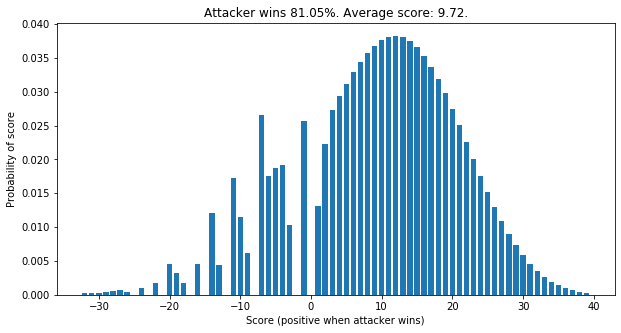

In [24]:
show(campaign_probdist(start))

**Interesting!** To the right of 0, we see a nice  bell-shaped curve. But there is a decidely non-normal pattern on the left side. There are gaps—scores for which the probability is zero—and there are spikes that rise above the normal curve. 

What's causing the gaps? We know that a campaign score can never be 0. And in this campaign, no score can be -2, because a -2 can only be achieved with the final state `(1, 2)`:  one attacker and two defenders in a single territory; this campaign has only one defender in the final territory, so `(1, 2)` could never occur. Looking at the plot, we see gaps surrounding groups of bars, where the group sizes, reading left to right, are 1, 1, 3, 1, 2, 3, 5, and 1. These are exactly the number of defenders in the final 8 territories, so the gaps are indicating the impossible scores.

What's causing the spikes? To some extent they represent probability mass that has shifted over a place from the impossible states to the neighboring possible states. But the spikes are not quite tall enough to fill in the gaps. I admit I don't understand the exact shape of each spike–do you?

In the plot below  all the defenders are in a single territory, and there is no visible gap–the normalish shape is restored. However, there is something going on with odd-versus-even scores. I believe that part of what is happening is that all but the very last few battles will be 3-versus-2 battles, and thus will result in 2 casualties, preserving the parity of the total number of armies. The parity is broken only in the final battles. But I don't think that's the full story—what do you think?

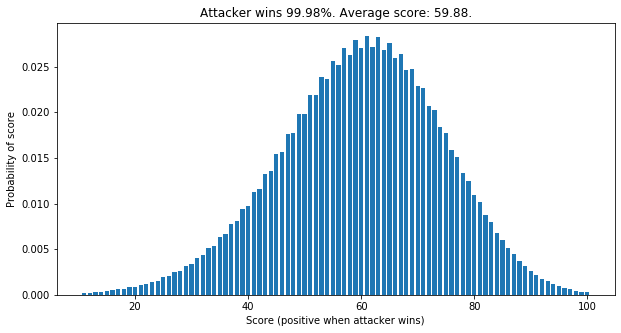

In [25]:
show(campaign_probdist((146, 100)))

The odd-even disparity can be lessened by adding a few territories where there will not be 3-versus-2 battles. The result is a very smooth curve, although not quite normal—it is clearly a bit fatter on the left than the right (the mean is 60 and the probability of 20 is greater than the probability of 100.

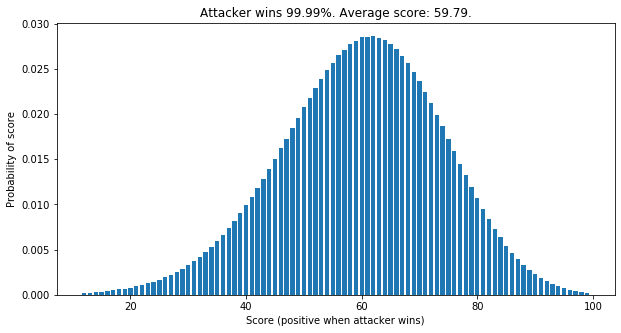

In [26]:
show(campaign_probdist((146, 93, 1, 1, 1, 1)))

# Analyzing Single-Territory Attacks

I want to analyze a simpler situation: With *A* attackers and *D* defenders in a single territory, what is the probability the attackers win?  

I will make a chart with the number of defenders varying from 1 to 60, and with the number of attackers separated into eight cases (depicted as eight lines), where in each case there are Δ more attackers than defenders:

In [27]:
def chart(defenders=range(1, 61), deltas=(9, 5, 2, 1, 0, -1, -2, -5)):
    """Plot win probability for various numbers of defenders and Δ more attackers."""
    plt.figure(figsize=(10, 5)); plt.grid()
    plt.title('Each line: attackers with Δ more armies than defenders')
    plt.xlabel('Number of Defenders'); plt.ylabel('Win Probability for Attackers')
    for delta in deltas:
        winprobs = [attacker_win_probability(campaign_probdist((max(0, d + delta), d))) 
                    for d in defenders]
        plt.plot(defenders, winprobs, 'o-', label=f'Δ = {delta:2}')
    plt.legend(shadow=True)

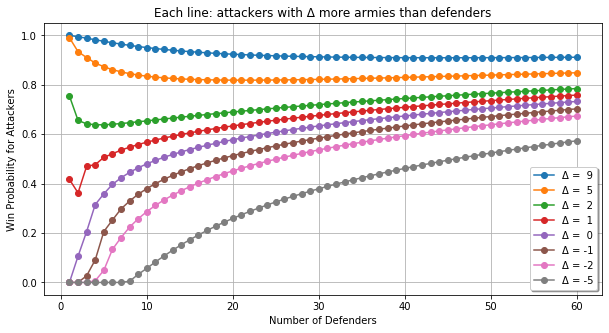

In [28]:
chart()

Note that the purple line (fourth from bottom), where the number of attackers exactly equals the number of defenders, gives a low win probability for a small attacking force, but reaches 50% for 12-on-12, and 73% for 60-on-60. The red line, where the attackers have one more army than the defenders, dips from one to two defenders but is over 50% for a 6-on-5 attack. Similarly, the green line, where the attackers have a surplus of two armies, dips sharply from 75% to 66% as the number of defenders goes from 1 to 2, dips slightly more for 3 and 4 defenders, and then starts to rise. So overall, an attacker does not need a big advantage in armies as long as there are many armies on both sides. Even when the attacker is at a disadvantage in numbers (as in the bottom grey line where the attacker has five fewer armies), the attacker can still have an advantage in win probability; with 55 against 60 the win percentage is about 57%.

# Tests

Here are regression unit tests that also serve as examples of usage.

In [29]:
# Tests for States
assert A(start)  == 72
assert D(start)  == 22 
assert allD(start) == (22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1)
assert sum(allD(start)) == 60 
assert len(allD(start)) == 14

# Tests for update
small = State((10, 2, 5)) # Small example where 10 attackers battle 2, then 5 dfenders
assert update(small, (0, 2)) == (9, 5)    # 2 defenders dead; occupy the first territory
assert update(small, (1, 1)) == (9, 1, 5) # continue to battle
assert update(small, (2, 0)) == (8, 2, 5) # continue to battle
assert update(start, (1, 1)) == (71, 21, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1)
assert update((9, 2), (0, 2)) == (8,) # Attackers occupied the final territory

# The 4 sample dice rolls from www.ultraboardgames.com/risk/game-rules.php
assert battle_deaths([1, 1, 6], [3,])   == (0, 1) # Defender loses one
assert battle_deaths([2, 6, 1], [2, 3]) == (1, 1) # Both lose one
assert battle_deaths([3, 3],    [3, 4]) == (2, 0) # Attacker loses two
assert battle_deaths([6,],      [5, 4]) == (0, 1) # Defender loses one

# All six possible battle dice combinations. The answers match those given at
# a Risk data analysis blog: http://datagenetics.com/blog/november22011/
assert battle_deaths_probdist((1, 1)) == ProbDist({(1, 0):   21, (0, 1):   15})
assert battle_deaths_probdist((2, 1)) == ProbDist({(1, 0):   91, (0, 1):  125})
assert battle_deaths_probdist((3, 1)) == ProbDist({(1, 0):  441, (0, 1):  855})
assert battle_deaths_probdist((1, 2)) == ProbDist({(1, 0):  161, (0, 1):   55})
assert battle_deaths_probdist((2, 2)) == ProbDist({(2, 0):  581, (1, 1):  420, (0, 2):  295})
assert battle_deaths_probdist((3, 2)) == ProbDist({(2, 0): 2275, (1, 1): 2611, (0, 2): 2890})

assert set(rolls(2)) == {(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), 
                         (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), 
                         (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), 
                         (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), 
                         (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), 
                         (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)}

assert attacker_win_probability(campaign_probdist((2, 1))) == 15/36
assert campaign_probdist((2, 1)) == ProbDist({(1, 1): 21/36, (1,): 15/36})
assert campaign_probdist((4, 2, 1)) == ProbDist(
    {(1, 2, 1): 0.21807067805974698,
     (1, 1, 1): 0.12597532213712342,
     (1, 1): 0.294669783648961,
     (1,): 0.14620529335276633,
     (2,): 0.21507892280140226})

assert battle_update_probdist(ProbDist({start: 1})) == ProbDist(
    {(70, 22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1): 0.2925668724279835,
     (71, 21, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1): 0.3357767489711934,
     (72, 20, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1): 0.37165637860082307})

True

True